In [1]:
# ===== 1.  Сносим не-подходящие версии (если ставились ранее) =====
!pip uninstall -y torch torchvision torchaudio torchtext torchdata || true

# ===== 2.  Ставим PyTorch 2.3.0 (stable) под CUDA 11.8 =====
!pip install -q torch==2.3.0+cu118 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# ===== 3.  Ставим PyTorch Geometric 2.5 и зависимые колёса =====
# Формула колёс → https://pytorch-geometric.com/quick-start
!pip install -q pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv \
  -f https://data.pyg.org/whl/torch-2.3.0+cu118.html
!pip install -q torch_geometric==2.5.*
!pip install focal-loss-torch

# ===== 4.  Утилиты для проекта =====
!pip install -q pandas scikit-learn networkx matplotlib rich tqdm
!pip install -q graphlime


Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Found existing installation: torchaudio 2.6.0+cu124
Uninstalling torchaudio-2.6.0+cu124:
  Successfully uninstalled torchaudio-2.6.0+cu124
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 839.7/839.7 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 39.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 89.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 728.5/728.5 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━

In [2]:
# @title Сиды
import os, random, numpy as np, torch
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
import sys, torch, torch_geometric, torch_scatter, pandas as pd, sklearn, networkx as nx
print("Python           :", sys.version.split()[0])
print("Torch            :", torch.__version__, "| CUDA:", torch.version.cuda, "| GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")
print("PyG              :", torch_geometric.__version__)
print("torch_scatter    :", torch_scatter.__version__)
print("pandas           :", pd.__version__)
print("scikit-learn     :", sklearn.__version__)
print("networkx         :", nx.__version__)

Python           : 3.11.12
Torch            : 2.3.0+cu118 | CUDA: 11.8 | GPU: CPU
PyG              : 2.5.3
torch_scatter    : 2.1.2+pt23cu118
pandas           : 2.2.2
scikit-learn     : 1.6.1
networkx         : 3.4.2


In [4]:
#@title 📂 Загрузка датасета (идемпотентно)
!rm -rf Labeled-Transactions-based-Dataset-of-Ethereum-Network
!git clone -q https://github.com/salam-ammari/Labeled-Transactions-based-Dataset-of-Ethereum-Network.git

import zipfile, pathlib
zip_path = "Labeled-Transactions-based-Dataset-of-Ethereum-Network/Dataset.zip"
extract_path = pathlib.Path("Labeled-Transactions-based-Dataset-of-Ethereum-Network/unpacked")
with zipfile.ZipFile(zip_path) as zf: zf.extractall(extract_path)
print("✅ Распаковка завершена")

✅ Распаковка завершена


In [5]:
#@title 🧹 Чтение CSV
import pandas as pd
dataset_csv_path = extract_path / "Dataset" / "Dataset.csv"
df = pd.read_csv(dataset_csv_path)
print(df.shape, "строк")
print(df.columns.tolist())

(71250, 18) строк
['hash', 'nonce', 'transaction_index', 'from_address', 'to_address', 'value', 'gas', 'gas_price', 'input', 'receipt_cumulative_gas_used', 'receipt_gas_used', 'block_timestamp', 'block_number', 'block_hash', 'from_scam', 'to_scam', 'from_category', 'to_category']


In [6]:
# @title 🧹 Этап 3 — очистка данных (актуальная версия)
import pandas as pd
import numpy as np

# --- 0. резервная копия ---
df_raw = df.copy()

# --- 1. числовые столбцы ---
num_cols = [
    "nonce", "transaction_index", "value", "gas", "gas_price",
    "receipt_cumulative_gas_used", "receipt_gas_used", "block_number"
]
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce", downcast="integer")

# --- 2. флаги мошенничества ---
df["from_scam"] = df["from_scam"].astype("int8")
df["to_scam"]   = df["to_scam"].astype("int8")

# --- 3. корректный разбор даты/времени блока ---
# ❶ заменяем ' UTC' → '+00:00' (делает формат единообразным)
ts_fixed = df["block_timestamp"].astype(str).str.replace(" UTC", "+00:00", regex=False)

# ❷ один вызов to_datetime, pandas ≥ 2.0 умеет format='mixed'
df["block_timestamp"] = pd.to_datetime(ts_fixed, utc=True, format="mixed", errors="raise")

# --- 4. удаляем записи без адресов ---
df.dropna(subset=["from_address", "to_address"], inplace=True)

# --- 5. убираем дубликаты по hash ---
dup_before = len(df)
df.drop_duplicates(subset="hash", inplace=True)
dup_removed = dup_before - len(df)

# --- 6. сброс индекса, сохранив исходный ---
df.reset_index(names="raw_row", inplace=True)

# --------- отладочный вывод ----------
print(f"➤ строк после очистки: {len(df)}  (исходно {len(df_raw)})")
print(f"   удалено дубликатов: {dup_removed}")
print("\nМетки транзакций:")
print("  from_scam =", dict(df['from_scam'].value_counts()))
print("  to_scam   =", dict(df['to_scam'].value_counts()))
print("\nТипы данных:")
print(df.dtypes.value_counts())
print("\nПервые 3 строки:")
display(df.head(3))

/usr/local/lib/python3.11/dist-packages/pandas/core/dtypes/cast.py:378: RuntimeWarning: invalid value encountered in cast
  new_result = trans(result).astype(dtype)


➤ строк после очистки: 71239  (исходно 71250)
   удалено дубликатов: 11

Метки транзакций:
  from_scam = {0: np.int64(68622), 1: np.int64(2617)}
  to_scam   = {0: np.int64(59601), 1: np.int64(11638)}

Типы данных:
object                 7
int32                  5
int64                  2
int8                   2
int16                  1
float64                1
datetime64[ns, UTC]    1
Name: count, dtype: int64

Первые 3 строки:


,raw_row,hash,nonce,transaction_index,from_address,to_address,value,gas,gas_price,input,receipt_cumulative_gas_used,receipt_gas_used,block_timestamp,block_number,block_hash,from_scam,to_scam,from_category,to_category
0,0,0x253ec84729f5c11437f5346830e6bdc9857171b16097...,370394,4,0x267be1c1d684f78cb4f6a176c4911b741e4ffdc0,0xd707ac0098599006f0857e8da4c950795645ba01,1.800000e+18,30000,22050000000,0x,129358,21000,2017-10-16 05:26:53+00:00,4370008,0x5e14d30d2155c0cdd65044d7e0f296373f3e92f65ebd...,0,0,NaN,NaN
1,1,0xfa5f1d7715562adb1e408fdbbbbfc033ae4fadca1e07...,229082,85,0x304cc179719bc5b05418d6f7f6783abe45d83090,0xb8f6e76d34d4877732dfefa6b6a4e2a834a9092b,7.500000e+15,90000,20609467870,0x,5415387,21000,2017-10-16 05:28:49+00:00,4370014,0x900efe010b41b8b6b135db041422fac80b69b96d93c2...,0,0,NaN,NaN
2,2,0x37928f1d12ee769d0876695aaa815c13d705f8b1e376...,229095,31,0x304cc179719bc5b05418d6f7f6783abe45d83090,0x5ec492652d7b92421680f21169ff6a8dbbc622ab,7.500000e+15,90000,20609467870,0x,1369625,21000,2017-10-16 05:29:19+00:00,4370015,0xfe7d1bc1c6257f92bacb0f8b1266c9894dda99b42e78...,0,0,NaN,NaN


In [7]:

# @title Инженерия признаков
import pandas as pd, numpy as np, re

# ---------- 1. вспом-функции ----------
def log1p_clip(col):           # логарифм со сдвигом
    return np.log1p(col).astype("float32")

# ---------- 2. агрегация по адресам ----------
g_from = (df
          .groupby("from_address")
          .agg(tx_out_count = ("hash",  "size"),
               tx_out_value = ("value", "sum"),
               first_out_ts = ("block_timestamp", "min"),
               last_out_ts  = ("block_timestamp", "max"))
         )

g_to = (df
        .groupby("to_address")
        .agg(tx_in_count = ("hash",  "size"),
             tx_in_value = ("value", "sum"),
             first_in_ts = ("block_timestamp", "min"),
             last_in_ts  = ("block_timestamp", "max"))
       )

nodes_df = g_from.join(g_to, how="outer")

# ---------- 3. заполняем пропуски адресно ----------
num_cols  = ["tx_out_count","tx_out_value","tx_in_count","tx_in_value"]
ts_cols   = ["first_out_ts","last_out_ts","first_in_ts","last_in_ts"]

nodes_df[num_cols] = nodes_df[num_cols].fillna(0).astype({"tx_out_count":"int32",
                                                          "tx_in_count":"int32"})
# временные оставляем как NaT – с ними корректно работают min/max

# ---------- 4. years_active ----------
first_ts = nodes_df[["first_out_ts","first_in_ts"]].min(axis=1, skipna=True)
last_ts  = nodes_df[["last_out_ts","last_in_ts"]].max(axis=1, skipna=True)

years = (last_ts - first_ts).dt.total_seconds() / (365*24*3600)
nodes_df["years_active"] = years.fillna(0).astype("float32")

# ---------- 5. логарифмируем суммы ----------
for col in ["tx_out_value","tx_in_value"]:
    nodes_df[col] = log1p_clip(nodes_df[col])

# ---------- 6. метка scam-узла ----------
scam_mask = pd.Series(0, index=nodes_df.index, dtype="int8")
scam_addr = pd.unique(pd.concat([df.loc[df["from_scam"]==1,"from_address"],
                                 df.loc[df["to_scam"]==1,"to_address"]]))
scam_mask.loc[scam_addr] = 1
nodes_df["is_scam"] = scam_mask

# ---------- 7. таблица рёбер ----------
edges_df = df[["from_address","to_address","value","block_timestamp"]].copy()
edges_df.rename(columns={"from_address":"source",
                         "to_address":"target"}, inplace=True)
edges_df["log_value"] = log1p_clip(edges_df["value"])
edges_df["ts_norm"]   = edges_df["block_timestamp"].astype("int64") / 1e9
edges_df.drop(columns=["value","block_timestamp"], inplace=True)

# ---------- 8. отладка ----------
print(f"Nodes : {nodes_df.shape}")
print(f"Edges : {edges_df.shape}")
print("\nSample nodes_df:")
display(nodes_df.head(3))
print("\nSample edges_df:")
display(edges_df.head(3))
print("\nlabel distribution:")
print(nodes_df['is_scam'].value_counts())

Nodes : (73034, 10)
Edges : (71239, 4)

Sample nodes_df:


,tx_out_count,tx_out_value,first_out_ts,last_out_ts,tx_in_count,tx_in_value,first_in_ts,last_in_ts,years_active,is_scam
0x00005b859f8fac331d73c5c70f74238876727498,1,39.143948,2018-02-10 03:42:50+00:00,2018-02-10 03:42:50+00:00,0,0.000000,NaT,NaT,0.0,0
0x00019beb6f68d1268288b6a458a8fd90dd266455,1,36.651409,2017-12-19 08:14:48+00:00,2017-12-19 08:14:48+00:00,0,0.000000,NaT,NaT,0.0,0
0x0002c3c259c3536c41b1c30e63b2f5bf0c7f98b7,0,0.000000,NaT,NaT,1,34.538776,2018-02-20 07:11:22+00:00,2018-02-20 07:11:22+00:00,0.0,0



Sample edges_df:


,source,target,log_value,ts_norm
0,0x267be1c1d684f78cb4f6a176c4911b741e4ffdc0,0xd707ac0098599006f0857e8da4c950795645ba01,42.034317,1.508132e+09
1,0x304cc179719bc5b05418d6f7f6783abe45d83090,0xb8f6e76d34d4877732dfefa6b6a4e2a834a9092b,36.553680,1.508132e+09
2,0x304cc179719bc5b05418d6f7f6783abe45d83090,0x5ec492652d7b92421680f21169ff6a8dbbc622ab,36.553680,1.508132e+09



label distribution:
is_scam
0    72865
1      169
Name: count, dtype: int64


In [8]:
# @title ▶️  Этап 5 — сборка Data-объекта PyG
import torch
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
import numpy as np

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# ---------- 1. address → numeric ID ----------
addr2id = {addr: i for i, addr in enumerate(nodes_df.index)}
num_nodes = len(addr2id)
print("num_nodes:", num_nodes)                        # 73 034

# ---------- 2. edge_index ----------
src = edges_df["source"].map(addr2id).to_numpy()
dst = edges_df["target"].map(addr2id).to_numpy()
edge_index = torch.tensor(np.vstack([src, dst]), dtype=torch.long)
print("edge_index shape :", edge_index.shape)         # [2, 71 239]

# ---------- 3. edge_attr ----------
edge_attr_cols = ["log_value", "ts_norm"]
edge_attr = torch.tensor(
    edges_df[edge_attr_cols].to_numpy(dtype=np.float32),
    dtype=torch.float32
)
print("edge_attr shape  :", edge_attr.shape)          # [71 239, 2]

# ---------- 4. node feature matrix x ----------
x_cols = ["tx_out_count", "tx_out_value",
          "tx_in_count",  "tx_in_value",
          "years_active"]
x = torch.tensor(
    nodes_df[x_cols].to_numpy(dtype=np.float32),
    dtype=torch.float32
)
print("x shape          :", x.shape)                  # [73 034, 5]

# ---------- 5. метки y ----------
y = torch.tensor(nodes_df["is_scam"].to_numpy(), dtype=torch.long)
print("positives in y   :", int(y.sum()))             # 169

# ---------- 6. train / val / test маски ----------
indices = np.arange(num_nodes)

# 50 % train, 25 % val, 25 % test — со стратификацией
train_idx, temp_idx = train_test_split(
    indices,
    test_size=0.5,
    stratify=y,
    random_state=SEED,
)
val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.5,
    stratify=y[temp_idx],
    random_state=SEED,
)

def to_mask(idxs, size):
    m = torch.zeros(size, dtype=torch.bool)
    m[idxs] = True
    return m

train_mask = to_mask(train_idx, num_nodes)
val_mask   = to_mask(val_idx,   num_nodes)
test_mask  = to_mask(test_idx,  num_nodes)

print("train / val / test:",
      train_mask.sum().item(),
      val_mask.sum().item(),
      test_mask.sum().item())                         # ≈ 36 517 / 18 259 / 18 258

# ---------- 7. Data object ----------
data = Data(
    x=x,
    edge_index=edge_index,
    edge_attr=edge_attr,
    y=y,
    train_mask=train_mask,
    val_mask=val_mask,
    test_mask=test_mask,
)

print("\nPyG Data summary:\n", data)

num_nodes: 73034
edge_index shape : torch.Size([2, 71239])
edge_attr shape  : torch.Size([71239, 2])
x shape          : torch.Size([73034, 5])
positives in y   : 169
train / val / test: 36517 18258 18259

PyG Data summary:
 Data(x=[73034, 5], edge_index=[2, 71239], edge_attr=[71239, 2], y=[73034], train_mask=[73034], val_mask=[73034], test_mask=[73034])


In [27]:
# @title ▶️  Этап 6 — определение модели и подготовка к обучению
import torch
from torch import nn
from torch_geometric.nn import GCNConv
from torch_geometric.utils import add_self_loops
from sklearn.metrics import recall_score
import numpy as np
from focal_loss import FocalLoss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ---------- 1. self-loops ----------
edge_index_sl, edge_attr_sl = add_self_loops(
    data.edge_index, data.edge_attr,
    num_nodes=data.num_nodes, fill_value="add"
)
data.edge_index = edge_index_sl
data.edge_attr  = edge_attr_sl

# ---------- 2. модель ----------
# (1) новая функция потерь
# вместо прежнего class_weights = torch.tensor([1., 72865/169])
N0, N1 = (data.y == 0).sum().item(), (data.y == 1).sum().item()
k = (N0 / N1) * 0.25          # «мягкий» коэффициент ≈ 108
weights = torch.tensor([1.0, k], device=device)   # порядок: [class0, class1]

criterion = FocalLoss(
    gamma    = 2.0,
    weights  = weights,        # ← обращаем внимание: **weights**, не weight
    reduction= 'mean'
)

# (2) чуть шире сеть, без Dropout
from torch_geometric.nn import GATConv

# ---------- 2. модель ----------
class GCN7(nn.Module):
    def __init__(self, in_feats):
        super().__init__()
        self.conv1 = GCNConv(in_feats,   4)
        self.conv2 = GCNConv(4,          32)
        self.conv3 = GCNConv(32,         16)
        self.conv4 = GCNConv(16,         16)
        self.conv5 = GCNConv(16,         16)
        self.conv6 = GCNConv(16,         4)
        self.conv7 = GCNConv(4,          2)   # output layer
        self.act   = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x, edge_index):
        x = self.act(self.conv1(x, edge_index))
        x = self.dropout(x)

        x = self.act(self.conv2(x, edge_index))
        x = self.dropout(x)

        x = self.act(self.conv3(x, edge_index))
        x = self.act(self.conv4(x, edge_index))
        x = self.act(self.conv5(x, edge_index))
        x = self.act(self.conv6(x, edge_index))

        x = self.conv7(x, edge_index)          # logits
        return x

model = GCN7(in_feats=data.x.size(1)).to(device)
print(model)

# ---------- 3. loss, optimizer ----------

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

# ---------- 4. utility: recall on a mask ----------
@torch.no_grad()
def masked_recall(logits, labels, mask):
    preds = logits[mask].argmax(dim=1).cpu()
    return recall_score(labels[mask].cpu(), preds, zero_division=0)

# ---------- 5. sanity check ----------
def model_size(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nTrainable params: {model_size(model):,}")
data = data.to(device)
out = model(data.x, data.edge_index)          # forward pass
print("Forward OK, logits shape:", tuple(out.shape))

Using device: cpu
GCN7(
  (conv1): GCNConv(5, 4)
  (conv2): GCNConv(4, 32)
  (conv3): GCNConv(32, 16)
  (conv4): GCNConv(16, 16)
  (conv5): GCNConv(16, 16)
  (conv6): GCNConv(16, 4)
  (conv7): GCNConv(4, 2)
  (act): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)

Trainable params: 1,334
Forward OK, logits shape: (73034, 2)


In [28]:
# @title ▶️ Этап 7 — обучение GNN (полная ячейка)
import torch
from torch import nn
from torch.optim import Adam
from sklearn.metrics import recall_score, confusion_matrix

# предполагается, что `data` (PyG Data) и `model` (GCN7) уже определены и находятся на устройстве device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
data  = data.to(device)

# --- 1) функция потерь и оптимизатор ---
# пример: взвешенный CrossEntropyLoss для борьбы с дисбалансом
N0, N1 = (data.y == 0).sum().item(), (data.y == 1).sum().item()
k      = (N0/N1) * 0.15           # вы можете скорректировать этот множитель
class_w = torch.tensor([1.0, k], device=device)
criterion = nn.CrossEntropyLoss(weight=class_w)

optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

# --- 2) параметры обучения ---
EPOCHS   = 20
PATIENCE = 3

best_rec   = 0.0
no_improve = 0
best_state = None

# --- 3) цикл обучения + валидация ---
for epoch in range(1, EPOCHS+1):
    model.train()
    optimizer.zero_grad()
    logits = model(data.x, data.edge_index)
    loss   = criterion(logits[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        logits_val = model(data.x, data.edge_index)
        val_loss   = criterion(logits_val[data.val_mask], data.y[data.val_mask]).item()
        val_pred   = logits_val[data.val_mask].argmax(dim=1).cpu()
        val_true   = data.y[data.val_mask].cpu()
        val_rec    = recall_score(val_true, val_pred, zero_division=0)

    print(f"Epoch {epoch:02d} | "
          f"train_loss {loss.item():.4f} | "
          f"val_loss   {val_loss:.4f} | "
          f"val_recall {val_rec:.3f}")

    # early stopping по recall
    if val_rec > best_rec:
        best_rec   = val_rec
        best_state = model.state_dict()
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= PATIENCE:
            print("Early stopping triggered.")
            break

# --- 4) тестовая оценка на best_state ---
model.load_state_dict(best_state)
model.eval()
with torch.no_grad():
    logits_test = model(data.x, data.edge_index)
    test_pred   = logits_test[data.test_mask].argmax(dim=1).cpu()
    test_true   = data.y[data.test_mask].cpu()
    test_rec    = recall_score(test_true, test_pred, zero_division=0)
    cm          = confusion_matrix(test_true, test_pred)

print(f"\nTest recall: {test_rec:.3f}")
print("Confusion matrix:\n", cm)

Epoch 01 | train_loss 3.6571 | val_loss   2.9412 | val_recall 1.000
Epoch 02 | train_loss 2.9943 | val_loss   2.7318 | val_recall 1.000
Epoch 03 | train_loss 2.0081 | val_loss   2.5394 | val_recall 1.000
Epoch 04 | train_loss 2.5281 | val_loss   2.3502 | val_recall 1.000
Early stopping triggered.

Test recall: 1.000
Confusion matrix:
 [[   27 18190]
 [    0    42]]


In [29]:
# @title Тест
from sklearn.metrics import precision_recall_curve

model.eval()
with torch.no_grad():
    logits = model(data.x, data.edge_index)
    probs  = logits.softmax(dim=1)[:, 1].cpu().numpy()
    y_all  = data.y.cpu().numpy()

# --- ищем порог на валидации ---
p, r, thr = precision_recall_curve(
    y_all[data.val_mask.cpu()],
    probs[data.val_mask.cpu()]
)

target_recall = 0.90                      # хотим ≥ 0.9
idx = np.where(r >= target_recall)[0][-1] # самый высокий precision при таком recall
best_thr = thr[idx]
print(f"chosen threshold = {best_thr:.3f}  (prec {p[idx]:.3f}  rec {r[idx]:.3f})")

# --- применяем на тесте ---
from sklearn.metrics import precision_score, recall_score, confusion_matrix
y_pred = (probs[data.test_mask.cpu()] > best_thr).astype(int)
y_true = y_all[data.test_mask.cpu()]

print("TEST  precision:", precision_score(y_true, y_pred, zero_division=0),
      "recall:",  recall_score(y_true, y_pred, zero_division=0))
print("confusion:\n", confusion_matrix(y_true, y_pred))

chosen threshold = 0.630  (prec 0.004  rec 0.905)
TEST  precision: 0.004062976130015236 recall: 0.9523809523809523
confusion:
 [[8412 9805]
 [   2   40]]


precision: 0.002  |  recall: 1.000  |  F1: 0.005
confusion:
 [[   27 18190]
 [    0    42]]


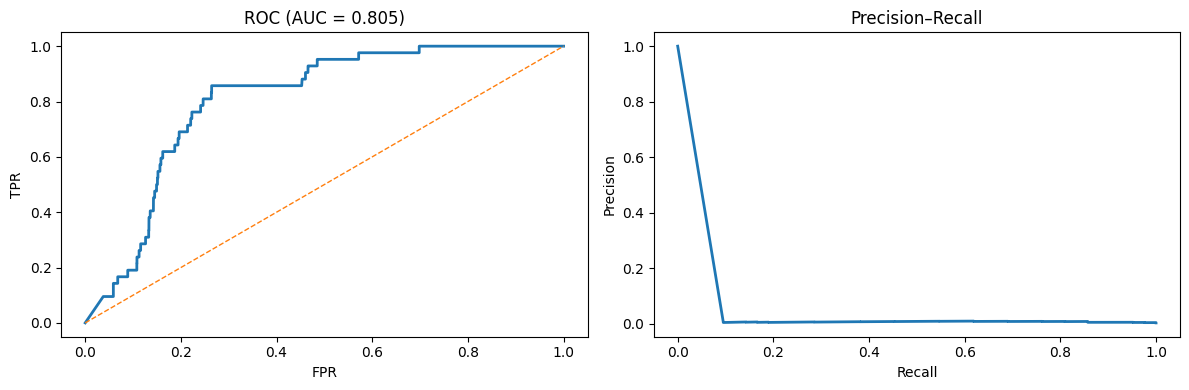

In [30]:
# ▶️  Этап 8 оценка GNN
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score, f1_score,
    roc_curve, auc, precision_recall_curve
)

model.load_state_dict(best_state)
model.eval()
with torch.no_grad():
    logits = model(data.x, data.edge_index).cpu()
    probs  = logits.softmax(dim=1)[:, 1].numpy()       # P(class=1)
    y_true = data.y.cpu().numpy()

mask = data.test_mask.cpu().numpy()                    # те же 18 259 узлов
y_pred = logits.argmax(dim=1).numpy()

# --- метрики на test ---
prec  = precision_score(y_true[mask], y_pred[mask], zero_division=0)
rec   = recall_score   (y_true[mask], y_pred[mask], zero_division=0)
f1    = f1_score       (y_true[mask], y_pred[mask], zero_division=0)
cm    = confusion_matrix(y_true[mask], y_pred[mask])

print(f"precision: {prec:.3f}  |  recall: {rec:.3f}  |  F1: {f1:.3f}")
print("confusion:\n", cm)

# --- ROC / PR кривые ---
fpr, tpr, _   = roc_curve(y_true[mask], probs[mask])
roc_auc       = auc(fpr, tpr)
prec_curve, rec_curve, _ = precision_recall_curve(y_true[mask], probs[mask])

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(fpr, tpr, lw=2)
plt.plot([0,1], [0,1], "--", lw=1)
plt.title(f"ROC (AUC = {roc_auc:.3f})"); plt.xlabel("FPR"); plt.ylabel("TPR")

plt.subplot(1,2,2)
plt.plot(rec_curve, prec_curve, lw=2)
plt.title("Precision–Recall"); plt.xlabel("Recall"); plt.ylabel("Precision")

plt.tight_layout()
plt.show()

In [31]:
# ▶️  Этап 9 сравнение
from sklearn.ensemble   import RandomForestClassifier
from sklearn.tree       import DecisionTreeClassifier
from sklearn.neighbors  import KNeighborsClassifier
from sklearn.metrics    import precision_recall_fscore_support
import joblib, pandas as pd
from collections import OrderedDict

X      = nodes_df[["tx_out_count","tx_out_value",
                   "tx_in_count","tx_in_value",
                   "years_active"]].values
y      = nodes_df["is_scam"].values
train_idx = data.train_mask.cpu().numpy()
test_idx  = data.test_mask .cpu().numpy()

models = OrderedDict({
    "RF":  RandomForestClassifier(
            n_estimators=200, class_weight="balanced", random_state=42),
    "DT":  DecisionTreeClassifier (class_weight="balanced", random_state=42),
    "KNN": KNeighborsClassifier   (n_neighbors=5, weights="distance")
})

scores = []
for name, clf in models.items():
    clf.fit(X[train_idx], y[train_idx])
    y_hat = clf.predict(X[test_idx])
    p, r, f, _ = precision_recall_fscore_support(
        y[test_idx], y_hat, zero_division=0, average="binary")
    scores.append((name, p, r, f))
    print(f"{name:3}  precision {p:.3f}  recall {r:.3f}  F1 {f:.3f}")

baseline_df = pd.DataFrame(scores, columns=["model","precision","recall","F1"])
baseline_df

RF   precision 0.366  recall 0.357  F1 0.361
DT   precision 0.060  recall 0.381  F1 0.104
KNN  precision 0.459  recall 0.405  F1 0.430


,model,precision,recall,F1
0,RF,0.365854,0.357143,0.361446
1,DT,0.060150,0.380952,0.103896
2,KNN,0.459459,0.404762,0.430380


In [32]:
# ▶️  Этап 10 Сохранение моделей и артефактов
import torch, joblib, json, datetime, os

timestamp = datetime.datetime.utcnow().strftime("%Y%m%d-%H%M%S")

# 1) GNN веса
gnn_path = f"gnn_fraud_{timestamp}.pt"
torch.save(model.state_dict(), gnn_path)

# 2) лучший baseline (RandomForest)
best_rfc = models["RF"]
rfc_path = f"baseline_rfc_{timestamp}.pkl"
joblib.dump(best_rfc, rfc_path)

# 3) лог метрик
metrics = {
    "gnn":  {"precision": float(prec),  "recall": float(rec),  "f1": float(f1)},
    "rf":   baseline_df.loc[baseline_df.model=="RF",  ["precision","recall","F1"]].iloc[0].to_dict(),
    "dt":   baseline_df.loc[baseline_df.model=="DT",  ["precision","recall","F1"]].iloc[0].to_dict(),
    "knn":  baseline_df.loc[baseline_df.model=="KNN", ["precision","recall","F1"]].iloc[0].to_dict(),
    "timestamp": timestamp
}
with open(f"metrics_{timestamp}.json", "w") as fp:
    json.dump(metrics, fp, indent=2)

print("Saved:")
print(" • GNN  →", gnn_path)
print(" • RFC  →", rfc_path)
print(" • metrics →", f"metrics_{timestamp}.json")

Saved:
 • GNN  → gnn_fraud_20250430-150606.pt
 • RFC  → baseline_rfc_20250430-150606.pkl
 • metrics → metrics_20250430-150606.json


In [34]:
model = GCN7(in_feats=5); model.load_state_dict(torch.load(gnn_path)); model.eval()
rf     = joblib.load(rfc_path)

In [43]:
import os
import datetime
import torch

# model — ваш GNN, у вас он называется gnn
# device, optimizer и т.д. уже настроены

# 1. Создаём папку, если нужно
os.makedirs("checkpoints", exist_ok=True)

# 2. Достаём текущую метку времени
ts = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# 3. Формируем имя файла
save_path = f"checkpoints/gnn_epoch10_{ts}.pt"

# 4. Сохраняем state_dict()
torch.save(model.state_dict(), save_path)

print(f"✅ Сохранён чекпоинт GNN: {save_path}")

✅ Сохранён чекпоинт GNN: checkpoints/gnn_epoch10_20250430-151216.pt


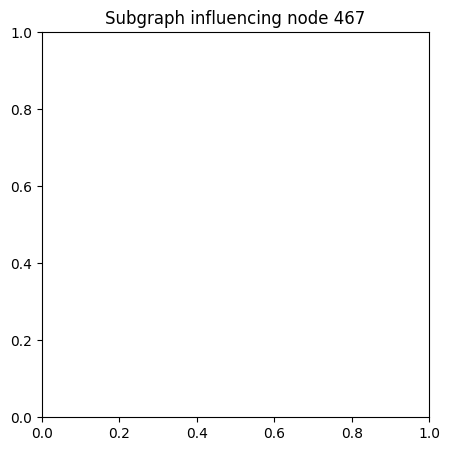

Feature importances:
  tx_out_count: 0.124
  tx_out_value: 0.160
  tx_in_count: 0.000
  tx_in_value: 0.000
  years_active: 0.134


In [39]:
# @title ▶️ GNNExplainer_ (работает под PyG 2.5.3 без ошибок)
from torch_geometric.explain.algorithm.gnn_explainer import GNNExplainer_
import networkx as nx
import matplotlib.pyplot as plt

# 1) Инициализация Explainer_ (принимает строки для return_type):
explainer = GNNExplainer_(
    model,
    epochs=200,
    lr=0.01,
    return_type='log_prob',       # лог-вероятности
    feat_mask_type='feature',     # маскируем признаки
    allow_edge_mask=True,         # маскируем рёбра
)

# 2) Выбираем узел для объяснения (первый мошенник):
node_idx = (data.y == 1).nonzero(as_tuple=False)[0].item()

# 3) Получаем маски важности:
node_feat_mask, edge_mask = explainer.explain_node(
    node_idx,
    x          = data.x,
    edge_index = data.edge_index,
)

# 4) Визуализируем «важные» рёбра
threshold = float(edge_mask.mean().cpu())
G = nx.Graph()
src, dst = data.edge_index.cpu().numpy()
for i, (u, v) in enumerate(zip(src, dst)):
    if edge_mask[i] > threshold:
        G.add_edge(int(u), int(v), weight=float(edge_mask[i].cpu()))

plt.figure(figsize=(5,5))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=20)
nx.draw_networkx_edges(
    G, pos,
    width=[d['weight']*5 for (_, _, d) in G.edges(data=True)]
)
plt.title(f"Subgraph influencing node {node_idx}")
plt.show()

# 5) Печатаем важность признаков для этого узла:
print("Feature importances:")
for feat_name, score in zip(x_cols, node_feat_mask.cpu()):
    print(f"  {feat_name}: {score:.3f}")

Explaining node: 467


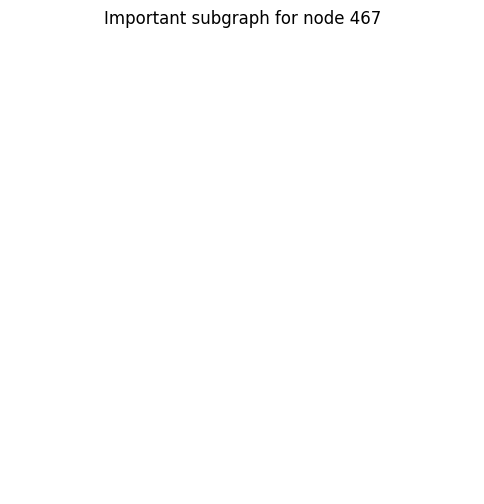

Feature importances:
  tx_out_count: 0.1379
  tx_out_value: 0.1464
  tx_in_count: 0.0000
  tx_in_value: 0.0000
  years_active: 0.1565


In [46]:
# ▶️ Этап Explainability — GNNExplainer_
import torch
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.explain.algorithm.gnn_explainer import GNNExplainer_

# 1) выберем узел для разбора (первый мошенник)
node_idx = (data.y == 1).nonzero(as_tuple=False)[0].item()
print("Explaining node:", node_idx)

# 2) инициализируем Explainer_ (epochs задаём позиционно!)
explainer = GNNExplainer_(
    model,                 # ваша GNN-модель
    200,                   # число итераций оптимизации масок
    lr=0.01,               # learning rate для масок
    return_type='log_prob',# хотим лог-вероятности
    feat_mask_type='feature',
    allow_edge_mask=True
)

# 3) получаем две маски:
#    node_feat_mask — важность каждой фичи узла
#    edge_mask      — важность каждого ребра в полном графе
node_feat_mask, edge_mask = explainer.explain_node(
    node_idx,
    x          = data.x,
    edge_index = data.edge_index,
)

# 4) визуализируем самый важный подграф
threshold = float(edge_mask.mean().cpu())
G = nx.Graph()
src, dst = data.edge_index.cpu().numpy()
for i, (u, v) in enumerate(zip(src, dst)):
    if edge_mask[i] > threshold:
        G.add_edge(int(u), int(v), weight=float(edge_mask[i].cpu()))

plt.figure(figsize=(6,6))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=30)
nx.draw_networkx_edges(
    G, pos,
    width=[d['weight']*5 for (_, _, d) in G.edges(data=True)],
    alpha=0.8
)
plt.title(f"Important subgraph for node {node_idx}")
plt.axis('off')
plt.show()

# 5) выводим важность признаков (в порядке x_cols)
print("Feature importances:")
for name, score in zip(x_cols, node_feat_mask.cpu()):
    print(f"  {name}: {score:.4f}")